In [2]:
# CodeP3.4F25 hex domain data (Task 3.2.5)
import keras, pandas as pd, numpy as np, tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as kb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Boundary coordinates (38 points)
xdata = [
    [0.0,0.0],[0.0,0.5],[0.0,1.0],[0.0,1.5],[0.0,2.0],[0.0,2.5],[0.0,3.0],[0.0,3.5],
    [0.0,4.0],[0.0,4.5],[0.0,5.0],[0.5,5.0],[1.0,5.0],[1.5,5.0],[2.0,5.0],[2.5,5.0],
    [3.0,5.0],[3.0,4.5],[3.0,4.0],[3.0,3.5],[3.0,3.0],[3.0,2.5],[3.0,2.0],[3.0,1.5],
    [3.0,1.0],[3.0,0.5],[3.0,0.0],[2.5,0.0],[2.0,0.0],[1.5,0.0],[1.0,0.0],[0.5,0.0],
    [0.5,1.0],[0.5,0.5],[1.0,0.5],[2.0,4.5],[2.5,4.5],[2.5,4.0]
]

# Boundary temperatures (38 values, aligned to xdata above)
ydata = [
    [50.],[50.],[50.],[50.],[50.],[45.],[40.],[35.],
    [30.],[25.],[20.],[15.],[10.],[10.],[10.],[10.],
    [10.],[10.],[10.],[10.],[10.],[15.],[20.],[25.],
    [30.],[35.],[40.],[45.],[50.],[50.],[50.],[50.],
    [50.],[50.],[50.],[10.],[10.],[10.]
]

xarray = np.array(xdata)
yarray = np.array(ydata)
print('xdata len', len(xarray), 'ydata len', len(yarray))
print(xarray)
print(yarray)

data_inputs = xarray
data_outputs = yarray
boundary_points_xtrain = tf.convert_to_tensor(xarray, dtype=tf.float32)
boundary_T_ytrain = tf.convert_to_tensor(yarray[:,0], dtype=tf.float32)
print(boundary_points_xtrain)
print(boundary_T_ytrain)


xdata len 38 ydata len 38
[[0.  0. ]
 [0.  0.5]
 [0.  1. ]
 [0.  1.5]
 [0.  2. ]
 [0.  2.5]
 [0.  3. ]
 [0.  3.5]
 [0.  4. ]
 [0.  4.5]
 [0.  5. ]
 [0.5 5. ]
 [1.  5. ]
 [1.5 5. ]
 [2.  5. ]
 [2.5 5. ]
 [3.  5. ]
 [3.  4.5]
 [3.  4. ]
 [3.  3.5]
 [3.  3. ]
 [3.  2.5]
 [3.  2. ]
 [3.  1.5]
 [3.  1. ]
 [3.  0.5]
 [3.  0. ]
 [2.5 0. ]
 [2.  0. ]
 [1.5 0. ]
 [1.  0. ]
 [0.5 0. ]
 [0.5 1. ]
 [0.5 0.5]
 [1.  0.5]
 [2.  4.5]
 [2.5 4.5]
 [2.5 4. ]]
[[50.]
 [50.]
 [50.]
 [50.]
 [50.]
 [45.]
 [40.]
 [35.]
 [30.]
 [25.]
 [20.]
 [15.]
 [10.]
 [10.]
 [10.]
 [10.]
 [10.]
 [10.]
 [10.]
 [10.]
 [10.]
 [15.]
 [20.]
 [25.]
 [30.]
 [35.]
 [40.]
 [45.]
 [50.]
 [50.]
 [50.]
 [50.]
 [50.]
 [50.]
 [50.]
 [10.]
 [10.]
 [10.]]
tf.Tensor(
[[0.  0. ]
 [0.  0.5]
 [0.  1. ]
 [0.  1.5]
 [0.  2. ]
 [0.  2.5]
 [0.  3. ]
 [0.  3.5]
 [0.  4. ]
 [0.  4.5]
 [0.  5. ]
 [0.5 5. ]
 [1.  5. ]
 [1.5 5. ]
 [2.  5. ]
 [2.5 5. ]
 [3.  5. ]
 [3.  4.5]
 [3.  4. ]
 [3.  3.5]
 [3.  3. ]
 [3.  2.5]
 [3.  2. ]
 [3.  1.5]
 [3.  1. ]
 [

In [3]:
# define neural network model
    
    #As seen below, we have created four dense layers. 
    #A dense layer is a layer in neural network that’s fully connected. 
    #In other words, all the neurons in one layer are connected to all other neurons in the next layer.
    #In the first layer, we need to provide the input shape, which is 1 in our case. 
    #The activation function we have chosen is elu, which stands for exponential linear unit. 
    
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
    
# Create your model (for example, a simple fully connected feedforward NN)
# Assume 2D input (x, y),  Output temperature T
model = Sequential([
        Dense(5, input_dim=2, activation='elu'),  
        Dense(10, activation='elu'),
        Dense(1)  
    ])  
    
# Set the kappa value (this can be adjusted as per your needs)
kappa = 1.3
    
# Set the x_max and y_max values of your domain ( can adjust these according to your problem)
x_max = 3.0
y_max = 5.0

#print summary of model features
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 15        
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________


In [4]:
# PINN CUSTOM LOSS FUNCTION - V.P. Carey, ME249 F25

import tensorflow as tf
from tensorflow.keras import backend as K

def custom_loss_function(kappa, x_max, y_max, epoch_tracker):
    """ Custom loss function for the neural network model.
        - kappa: weight for the Laplace residual term.
        - x_max, y_max: maximum x and y coordinates of the domain.
        - epoch_tracker: callback object to keep track of the current epoch. """
    
    def loss(y_true, y_pred):    
        # Define pointsBoundaryChk as a constant tensor
        pointsBoundaryChk = tf.constant([
            [ 0.0, 0.0 ], [ 0.0, 0.5 ], [ 0.0, 1.0 ], [ 0.0, 1.5 ], [ 0.0, 2.0 ], [ 0.0, 2.5 ], [ 0.0, 3.0 ], [ 0.0, 3.5 ],
            [ 0.0, 4.0 ], [ 0.0, 4.5 ], [ 0.0, 5.0 ], [ 0.5, 5.0 ], [ 1.0, 5.0 ], [ 1.5, 5.0 ], [ 2.0, 5.0 ], [ 2.5, 5.0 ],
            [ 3.0, 5.0 ], [ 3.0, 4.5 ], [ 3.0, 4.0 ], [ 3.0, 3.5 ], [ 3.0, 3.0 ], [ 3.0, 2.5 ], [ 3.0, 2.0 ], [ 3.0, 1.5 ],
            [ 3.0, 1.0 ], [ 3.0, 0.5 ], [ 3.0, 0.0 ], [ 2.5, 0.0 ], [ 2.0, 0.0 ], [ 1.5, 0.0 ], [ 1.0, 0.0 ], [ 0.5, 0.0 ],
            [ 0.5, 1.0 ], [ 0.5, 0.5 ], [ 1.0, 0.5 ], [ 2.0, 4.5 ], [ 2.5, 4.5 ], [ 2.5, 4.0 ]
        ], dtype=tf.float32)
        
        # Boundary loss: Calculate squared error for the boundary condition
        boundary_loss = K.mean(K.square(y_pred - y_true))
        
        ESbdsum = 0.
        for _ in range(32):
            # Sample a random index and gather point
            idx = tf.random.uniform(shape=[], minval=0, maxval=32, dtype=tf.int32)
            selected_point = tf.gather(pointsBoundaryChk, idx)
                
            # Stack selected_point as input for the model (shape becomes (1, 2))
            input_tensor = tf.expand_dims(selected_point, axis=0)
            # Pass input_tensor as the input to the model
            T_pred_at_boundxy = model(input_tensor)  # Model prediction
            # add penalty if temperature at flux location is OUTSIDE RANGE 5-55 DEG C
            if (T_pred_at_boundxy < 5.):
                ESbdsum += 20.*(5. - T_pred_at_boundxy)*(5. - T_pred_at_boundxy)
            if (T_pred_at_boundxy > 55.):
                ESbdsum += 20.*(T_pred_at_boundxy - 55.)*(T_pred_at_boundxy - 55.)
        boundary_loss += ESbdsum/32.
    
        # Check epoch from the callback
        epoch = epoch_tracker.epochs_trained
            
        # If current epoch is less than N_epInit, ignore the Laplace residual
        if epoch < epoch_tracker.N_epInit:
            total_loss = boundary_loss
        else:
            # 3. Randomly select an interior point from this list using TensorFlow's random uniform
            points = tf.constant([
                [ 1.5, 0.5 ], [ 2.0, 0.5 ], [ 2.5, 0.5 ],
                [ 1.0, 1.0 ], [ 1.5, 1.0 ], [ 2.0, 1.0 ], [ 2.5, 1.0 ],
                [ 0.5, 1.5 ], [ 1.0, 1.5 ], [ 1.5, 1.5 ], [ 2.0, 1.5 ], [ 2.5, 1.5 ],
                [ 0.5, 2.0 ], [ 1.0, 2.0 ], [ 1.5, 2.0 ], [ 2.0, 2.0 ], [ 2.5, 2.0 ],
                [ 0.5, 2.5 ], [ 1.0, 2.5 ], [ 1.5, 2.5 ], [ 2.0, 2.5 ], [ 2.5, 2.5 ],
                [ 0.5, 3.0 ], [ 1.0, 3.0 ], [ 1.5, 3.0 ], [ 2.0, 3.0 ], [ 2.5, 3.0 ],
                [ 0.5, 3.5 ], [ 1.0, 3.5 ], [ 1.5, 3.5 ], [ 2.0, 3.5 ], [ 2.5, 3.5 ],
                [ 0.5, 4.0 ], [ 1.0, 4.0 ], [ 1.5, 4.0 ], [ 2.0, 4.0 ], [ 2.5, 4.0 ],
                [ 0.5, 4.5 ], [ 1.0, 4.5 ], [ 1.5, 4.5 ]
            ], dtype=tf.float32)
            
            meanLap_res = 0.
            meanTlimPen = 0.
            for _ in range(45):
                ##compute Laplacian residue here - need to do this once per BC point - include in range 32 loop =======
                # Use tf.random.uniform to sample an index for the interior point
                idx = tf.random.uniform(shape=[], minval=0, maxval=45, dtype=tf.int32)
                selected_point = tf.gather(points, idx)
                x_interior, y_interior = selected_point[0], selected_point[1],
                
                # Use tf.GradientTape to compute second derivatives
                with tf.GradientTape(persistent=True) as tape:
                    tape.watch(selected_point)
                    # Pass the selected (x_interior, y_interior) to the model to get T_pred_at_interior
                    T_pred_at_interior = model([x_interior, y_interior])  # Model prediction
                
                # Compute first derivatives with respect to x and y
                dT_dx = tape.gradient(T_pred_at_interior, selected_point[0])
                dT_dy = tape.gradient(T_pred_at_interior, selected_point[1])
                
                # Compute second derivatives (Hessian)
                d2T_dx2 = tape.gradient(dT_dx, selected_point[0])
                d2T_dy2 = tape.gradient(dT_dy, selected_point[1])
                
                # Calculate the Laplacian (sum of second derivatives)
                laplacian = d2T_dx2 + d2T_dy2
                
                # Compute the Laplacian residual (sum of squared Laplacian)
                meanLap_res +=  K.square(laplacian)/45.
                
                # ADD PENALTY IF T below 5 or above 55
            
                if (T_pred_at_interior < 5.):
                    meanTlimPen += 20.*(5. - T_pred_at_interior)*(5. - T_pred_at_interior)/45.
                if (T_pred_at_interior > 55.):
                    meanTlimPen += 20.*(T_pred_at_interior - 55.)*(T_pred_at_interior - 55.)/45.
                
            #Combine three losses
            total_loss = boundary_loss + kappa * meanLap_res + meanTlimPen

    
        return total_loss
    return loss
    

In [5]:
# Compile and train for hex domain (kappa=5.0)
from tensorflow.keras.callbacks import Callback
class EpochTracker(Callback):
    def __init__(self, N_epInit):
        super().__init__()
        self.N_epInit = N_epInit
        self.epochs_trained = 0
    def on_epoch_end(self, epoch, logs=None):
        self.epochs_trained = epoch

epoch_tracker = EpochTracker(N_epInit=2)
custom_loss = custom_loss_function(kappa=4.0, x_max=3.0, y_max=5.0, epoch_tracker=epoch_tracker)

import tensorflow as tf
model = Sequential([
    Dense(5, input_dim=2, activation='elu'),
    Dense(10, activation='elu'),
    Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=9e-3), loss=custom_loss)

historyData = model.fit(
    boundary_points_xtrain, boundary_T_ytrain,
    epochs=40000, batch_size=32, callbacks=[epoch_tracker], verbose=0
)
loss_hist = historyData.history['loss']
best_epoch = int(tf.math.argmin(loss_hist)) + 1
best_loss = float(min(loss_hist))
print('best epoch =', best_epoch)
print('smallest loss =', best_loss)

predictions = model.predict(data_inputs)

import pathlib, json
pathlib.Path('outputs/part4').mkdir(parents=True, exist_ok=True)
json.dump({'best_epoch': best_epoch, 'best_loss': best_loss}, open('outputs/part4/metrics_hex_kappa5.json','w'), indent=2)


2025-11-26 12:48:44.284161: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


best epoch = 39961
smallest loss = 0.025061771273612976
2/2 [==============================] - 0s 925us/step


2/2 [==============================] - 0s 761us/step


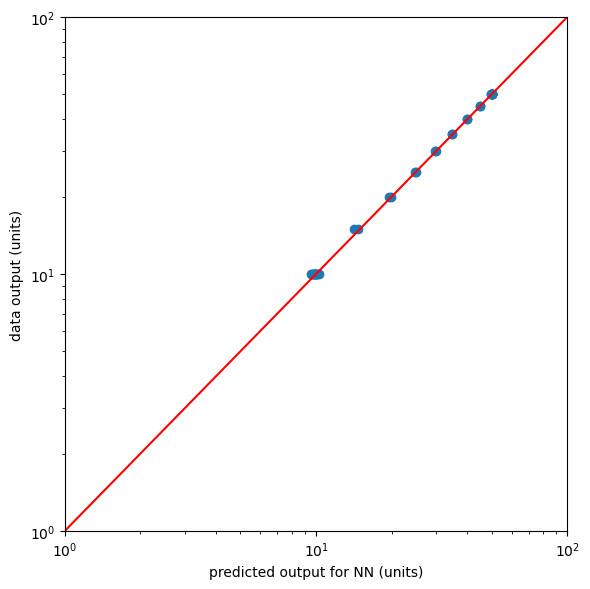

1/1 [==============================] - 0s 9ms/step
x=  0.0 , y=  0.0 T=  50.046867
1/1 [==============================] - 0s 9ms/step
x=  0.0 , y=  0.5 T=  50.03724
1/1 [==============================] - 0s 7ms/step
x=  0.0 , y=  1.0 T=  49.949574
1/1 [==============================] - 0s 10ms/step
x=  0.0 , y=  1.5 T=  49.782497
1/1 [==============================] - 0s 10ms/step
x=  0.0 , y=  2.0 T=  49.93066
1/1 [==============================] - 0s 8ms/step
x=  0.0 , y=  2.5 T=  44.96487
1/1 [==============================] - 0s 8ms/step
x=  0.0 , y=  3.0 T=  39.818554
1/1 [==============================] - 0s 8ms/step
x=  0.0 , y=  3.5 T=  34.76697
1/1 [==============================] - 0s 8ms/step
x=  0.0 , y=  4.0 T=  29.88401
1/1 [==============================] - 0s 8ms/step
x=  0.0 , y=  4.5 T=  24.878357
1/1 [==============================] - 0s 8ms/step
x=  0.0 , y=  5.0 T=  19.589867
1/1 [==============================] - 0s 8ms/step
x=  0.5 , y=  0.0 T=  50.123066
1/1 [==

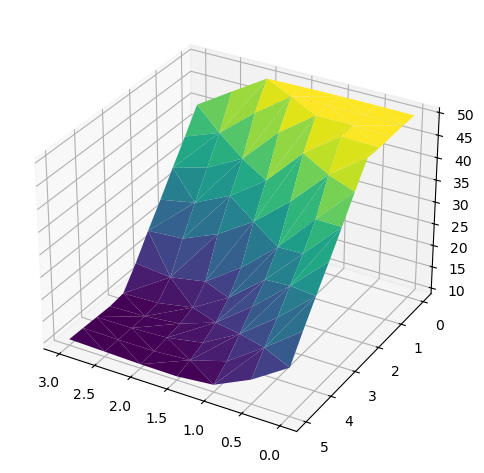

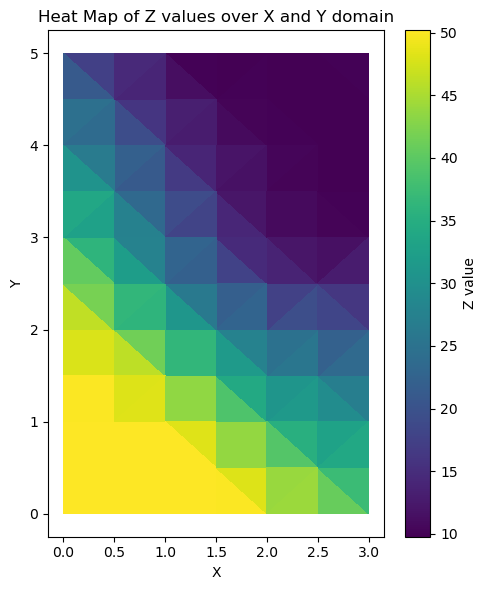

In [ ]:
# Plotting (base names use learning rate + kappa)
import numpy as np, os, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
os.makedirs('outputs/part4', exist_ok=True)
base = 'lr9e-3_kappa4.0'

# Scatter plot: predictions vs data (current model predictions)
predictions = model.predict(data_inputs)
plt.figure(figsize=(6,6))
plt.scatter(predictions[:, 0], data_outputs[:, 0])
plt.xlabel('predicted output for NN (units)')
plt.ylabel('data output (units)')
plt.loglog()
plt.xlim(xmax = 100, xmin = 1.)
plt.ylim(ymax = 100, ymin = 1.)
x_data = np.linspace(1.0, 100.0, num=3)
y_data = x_data
plt.plot(x_data, y_data, color='red')
plt.tight_layout()
plt.savefig(f'outputs/part4/{base}_scatter.png', dpi=200)
plt.show()

# Calculate grid predictions and plot surface/heatmap
xa=[]; ya=[]; za=[]
x =-0.50
ia=-1
while (x < 2.51):
    x = x + 0.5
    y = -0.5
    while (y < 4.51):
        ia=ia+1
        y = y + 0.50
        xa.append(x)
        ya.append(y)
        outpt = model.predict(np.array([[x,y]]))
        za.append(outpt[0][0])
        print ('x= ', x, ', y= ', y,'T= ', outpt[0][0])

X, Y, Z = xa, ya, za

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot_trisurf(X, Y, Z, linewidth = 0.2, antialiased = True , cmap='viridis');
ax.invert_yaxis()
ax.invert_xaxis()
plt.tight_layout()
plt.savefig(f'outputs/part4/{base}_surface.png', dpi=220)
plt.show()

plt.figure(figsize=(5, 6))
plt.tripcolor(xa, ya, za, shading='flat', cmap='viridis')
plt.colorbar(label='Z value')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Heat Map of Z values over X and Y domain')
plt.tight_layout()
plt.savefig(f'outputs/part4/{base}_heatmap.png', dpi=220)
plt.show()
